## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [3]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from torch.nn.utils import clip_grad_norm_
import time
import logging
import gensim
import os
import glob
import sys

### 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [4]:


# Read raw data in lunyu_20chapters.txt
log_file = 'A2_3.log'
os.remove(log_file)
# 配置日志记录器
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# 配置日志处理程序

# if os.path.exists(log_file):
#     open(log_file, 'w').close()
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)

# 配置日志格式
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# 配置日志处理程序 - 控制台处理程序
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)

# 将控制台处理程序添加到日志记录器
logger.addHandler(console_handler)

# 将处理程序添加到日志记录器
logger.addHandler(file_handler)

### YOUR CODE HERE ###
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)
with open('lunyu_20chapters.txt', 'r', encoding='utf-8') as file:
    raw_data = file.read()
raw_data=raw_data.replace('\n','')
# print(raw_data[:10])

### END YOUR CODE ###

Total vocabulary: 1352


In [5]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    word_ids = [corpus.word2id[word] for word in words]  # Convert the list of words to a list of word ids

    for center_index, center_id in enumerate(word_ids):
        context_indices = None
        # Iterate over the left context words
        for i in range(max(0, center_index - window_size), center_index):
            context_indices=word_ids[i]
            negative_samples = corpus.getNegatives(center_id, k)
            yield center_id, context_indices, negative_samples

        # Iterate over the right context words
        for i in range(center_index + 1, min(center_index + window_size + 1, len(word_ids))):
            context_indices=word_ids[i]
            negative_samples = corpus.getNegatives(center_id, k)
            yield center_id, context_indices, negative_samples

    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        ### YOUR CODE HERE ###
        center_batch = []
        outside_batch = []
        negative_batch = []

        for center, outside, negative in batch:
            center_batch.append(center)
            outside_batch.append(outside)
            negative_batch.append(negative)

        center_tensor = torch.tensor(center_batch, dtype=torch.long)
        outside_tensor = torch.tensor(outside_batch, dtype=torch.long)
        negative_tensor = torch.tensor(negative_batch, dtype=torch.long)

        yield center_tensor, outside_tensor, negative_tensor

        ### END YOUR CODE ###


data = list(generate_data(list(raw_data), window_size=3, k=5, corpus=corpus))
print("generate_data")
print(data[:5])

batches = list(batchify(data, batch_size=4))
print("batchify")
print(batches[0])

generate_data
[(1, 4, array([204, 349,  38, 371,  46])), (1, 3, array([ 99, 201,  34, 345,   9])), (1, 46, array([ 271,  388,  105,  238, 1180])), (4, 1, array([ 19, 943,  28, 461, 238])), (4, 3, array([  3, 349, 205,  12, 237]))]


/var/folders/2s/8cp0j_3x6ts54xdw2_dpwhrh0000gn/T/ipykernel_81060/2865262044.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  negative_tensor = torch.tensor(negative_batch, dtype=torch.long)


batchify
(tensor([1, 1, 1, 4]), tensor([ 4,  3, 46,  1]), tensor([[ 204,  349,   38,  371,   46],
        [  99,  201,   34,  345,    9],
        [ 271,  388,  105,  238, 1180],
        [  19,  943,   28,  461,  238]]))


### 2. Build the Model

In [6]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        ### YOUR CODE HERE ###
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        #
        # ### YOUR CODE HERE ###
        # Positive sample score
        pos_score = torch.sum(torch.mul(v_c, u_o), dim=1)  # (B,)
        pos_loss = F.logsigmoid(torch.clamp(pos_score, min=-10, max=10))  # (B,)

        # Negative sample scores
        neg_score = torch.bmm(u_n, v_c.unsqueeze(2)).squeeze(2)  # (B, k)
        neg_loss = F.logsigmoid(torch.clamp(-neg_score, min=-10, max=10))  # (B, k)

        # Combine losses
        loss = -torch.sum(pos_loss + torch.sum(neg_loss, dim=1))  # Scalar

        # Hint: torch.clamp the input to F.logsigmoid to avoid numerical underflow/overflow
        ### END YOUR CODE ###

        return loss
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

### 3. Train and Evaluate

Total vocabulary: 1352


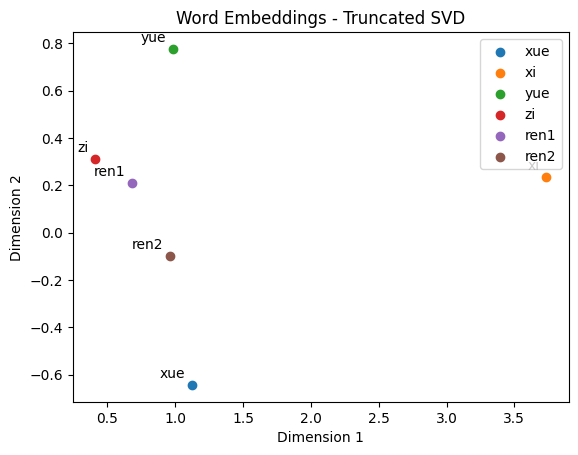

Total vocabulary: 1352


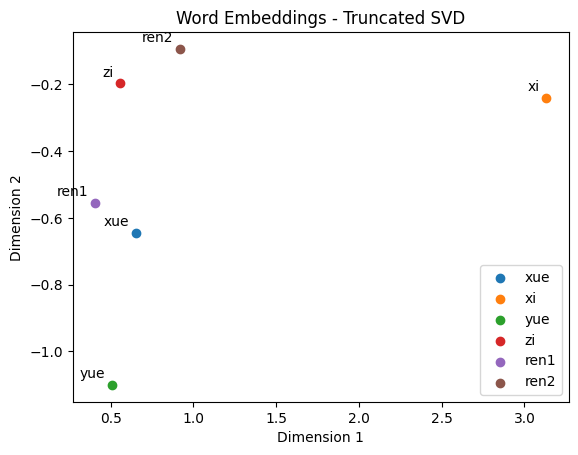

Total vocabulary: 1352


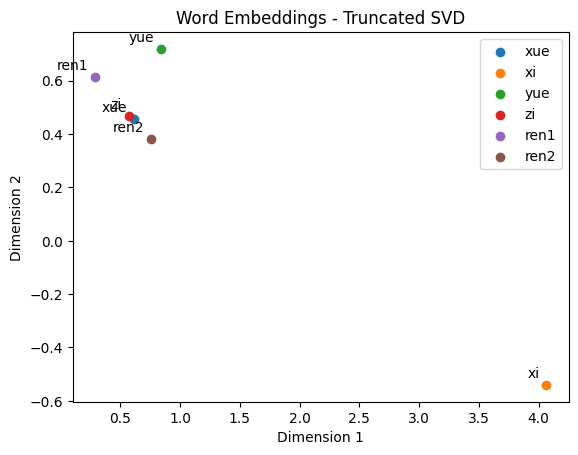

Total vocabulary: 1352


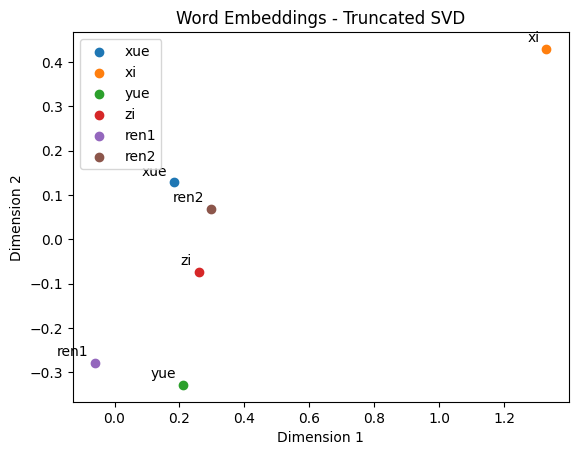

Total vocabulary: 1352


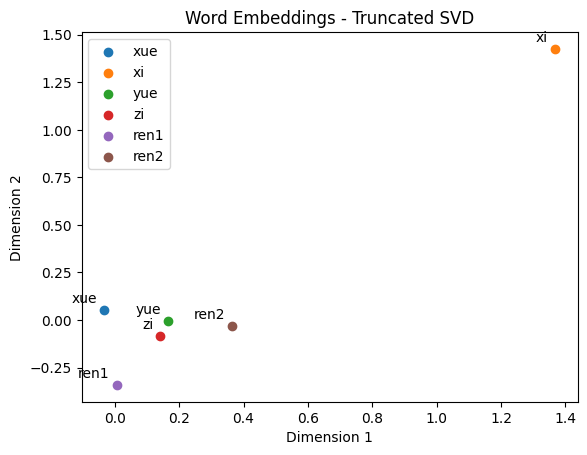

Total vocabulary: 1352


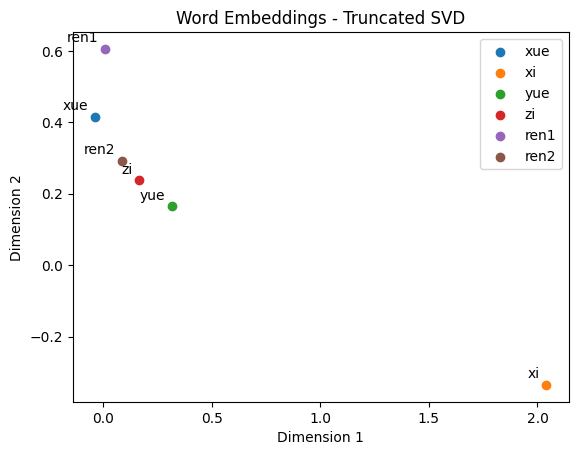

Total vocabulary: 1352


In [ ]:

def train(model, dataloader, optimizer, scheduler, epochs):
    # Write your own code for this train function
    # You don't need exactly the same arguments

    ### YOUR CODE HERE ###
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine the device (GPU or CPU)
    model.to(device)  # Move the model to the appropriate device
    model.train()  # Set the model to training mode

    print_interval = 1000  # Print loss every 1000 iterations

    for epoch in range(epochs):
        total_loss = 0.0
        iterations = 0

        for i, (center_word, context_word, negative_words) in enumerate(dataloader):
            center_word = center_word.to(device)
            context_word = context_word.to(device)
            negative_words = negative_words.to(device)

            optimizer.zero_grad()

            loss = model(center_word, context_word, negative_words)  # Forward pass

            loss.backward()  # Backward pass

            dense_params = [param.clone().detach().to(device) for param in model.parameters() if param.requires_grad]
            clip_grad_norm_(dense_params, max_norm=5.0)

            # clip_grad_norm_(model.parameters(), max_norm=5.0)  # Clip gradients to avoid exploding gradients

            optimizer.step()

            total_loss += loss.item()
            iterations += 1

            if (i + 1) % print_interval == 0:
                avg_loss = total_loss / iterations
                logger.info(f"Epoch [{epoch+1}/{epochs}], Iteration [{i+1}/{len(dataloader)}], Loss: {avg_loss}")

        scheduler.step()  # Update learning rate scheduler

    ### END YOUR CODE ###


# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_sizes = [50,100]
window_sizes = [1,3,5]
ks = [5,10,15] # the number of negative samples, change with your own choice for better embedding performance
min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function

# epochs=6差不多
epochs=10
vacob_size = len(corpus.id2word)

count=0
for emb_size in emb_sizes:
    for window_size in window_sizes:
        for k in ks:
            count+=1
            logger.info(f"Config {count}: ")
            logger.info(f"Hyper-parameters:emb_size={emb_size},window_size={window_size},k={k}")
            embedding_file_name=f"embeddings_2/{emb_size}_{window_size}_{k}.txt"
            # model_name=f"{emb_size}_{window_size}_{k}.pth"
            logger.info(f"Saved embedding file name:{embedding_file_name}")
            generated_data= list(generate_data(list(raw_data), window_size=window_size, k=k, corpus=corpus))
            dataloader = list(batchify(generated_data, batch_size=4))
            # Initialize the corpus and model
            corpus = CorpusReader('lunyu_20chapters.txt', min_count)
            model = SkipGram(vacob_size, emb_size)

            optimizer = torch.optim.SparseAdam(model.parameters(),lr=initial_lr) # or torch.optim.SparseAdam() or torch.optim.Adam()
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(dataloader)*epochs)  # or torch.optim.lr_scheduler.StepLR()
            # scheduler=torch.optim.lr_scheduler.StepLR()

            train(model, dataloader, optimizer, scheduler,epochs)

            # torch.save(model.state_dict(), model_name)
            model.save_embedding(corpus.id2word,file_name=embedding_file_name)

            # Get embeddings as numpy array
            embeddings = model.emb_v.cpu().weight.data.numpy()

            # Truncated SVD
            svd = TruncatedSVD(n_components=2)
            embeddings_2d = svd.fit_transform(embeddings)


            # Plot the embeddings
            words = ['学', '习', '曰', '子', '人', '仁']
            words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

            # plt.figure(figsize=(10, 10))
            for i, word in enumerate(words):
                x, y = embeddings_2d[corpus.word2id[word]]
                plt.scatter(x, y, label=words_pinyin[i])
                plt.annotate(words_pinyin[i], (x, y), textcoords="offset points", xytext=(-5, 5), ha='right')

            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.title('Word Embeddings - Truncated SVD')
            plt.legend()

            image_name = f"embeddings_2/{emb_size}_{window_size}_{k}.png"
            # Save the figure
            plt.savefig(image_name)

            # Show the plot
            plt.show()



### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done


### 4. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [ ]:


####在上面一起实现了


# # Load embeddings
# ### YOUR CODE HERE ###
# embeddings = model.emb_v.cpu().data.numpy()
# folder_path = 'embeddings'  # 指定文件夹路径
#
# # 使用 glob 模块匹配文件夹下所有以 .txt 结尾的文件
# txt_files = glob.glob(os.path.join(folder_path, '*.txt'))
#
# # 遍历匹配到的文件列表
# for file_path in txt_files:
#     print(file_path)
#     model = gensim.models.KeyedVectors.load_word2vec_format(file_path)
#
#     ### END YOUR CODE ###
#     # Truncated SVD
#     ### YOUR CODE HERE ###
#     svd = TruncatedSVD(n_components=2)
#     embeddings_2d = svd.fit_transform(embeddings)
#     ### END YOUR CODE ###
#     # Plot the following words or other words you are interested in
#     # You better pick those words that look different in the 2D space compared with the LSA vectors
#     words = ['学', '习', '曰', '子', '人', '仁']
#     words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']
#
#     ### YOUR CODE HERE ###
#     plt.figure(figsize=(10, 10))
#     for i, word in enumerate(words):
#         x, y = embeddings_2d[model.word2id[word]]
#         plt.scatter(x, y, label=word)
#         plt.annotate(words_pinyin[i], (x, y), textcoords="offset points", xytext=(-5,5), ha='right')
#
#     plt.xlabel('Dimension 1')
#     plt.ylabel('Dimension 2')
#     plt.title('Word Embeddings - Truncated SVD')
#     plt.legend()
#     # Save the figure
#     file_name = os.path.splitext(os.path.basename(file_path))[0]
#     plt.savefig(f'embeddings/{file_name}.png')
#
#     # Show the plot
#     plt.show()
#     ### END YOUR CODE ###